# Prediction and reconstruction for one beat

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append("../")

# This is a no-no in prod code. Use PYTHONPATH variable in shell instead

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.signal import find_peaks

from reconstruct import get_exam_ids_per_file, extract_selected_tracings, reconstruct_traces

# Read file and filter

1. Read a hfd5 file; file number `file_num` from constants.py
2. The whole file may not fit in the laptop memory
3. For now, good filters are:
   * normal_ecg = True
   * abs(age - nn_predicted_age) < 1
4. df = metadata - the `exam_id` is used to read only part of the hfd5 file 
5. trace_file_path - path of the massive hfd5 file to be read. Depends upon the `file_num` variable.

In [4]:
trace_file_path, df = get_exam_ids_per_file()

2025-09-12 20:32:36 INFO     Found 10923 patients in file num 16.


In [5]:
df.head()

,exam_id,age,is_male,nn_predicted_age,1dAVb,RBBB,LBBB,SB,ST,AF,patient_id,death,timey,normal_ecg,trace_file
7057,1683849,35,False,35.244183,False,False,False,False,False,False,1397534,NaN,NaN,True,exams_part16.hdf5
7265,1754825,49,False,49.684593,False,False,False,False,False,False,959059,NaN,NaN,True,exams_part16.hdf5
7281,1689108,41,False,40.222874,False,False,False,False,False,False,1500679,False,1.101369,True,exams_part16.hdf5
7446,1715430,48,False,47.940437,False,False,False,False,False,False,1499416,NaN,NaN,True,exams_part16.hdf5
7448,1796928,41,True,41.678860,False,False,False,False,False,False,673061,False,0.915068,True,exams_part16.hdf5


In [6]:
df.shape

(772, 15)

In [7]:
trace_file_path

'../data/exams_part16.hdf5'

In [8]:
! ls ../data/exams_part16.hdf5

../data/exams_part16.hdf5


# Filter the hfd5 file

1. Read the dataframe, for the `exam_id` column
2. Take in the `trace_file_path`
3. Read that file, but only read the given `exam_id`s from the dataframe
4. If trying to read the whole hfd5 file in Jupyter Notebook - the kerner dies. RIP.

In [9]:
selected_traces = extract_selected_tracings(
    trace_file_path,
    df['exam_id'].values
)

2025-09-12 20:32:36 INFO     reading trace file: ../data/exams_part16.hdf5
2025-09-12 20:32:36 INFO     Found tracings
2025-09-12 20:32:36 INFO     Saved npy file


The np.array `selected_traces` is 3 dimentional -
* axis 0 - patients
* axis 1 - individual ECG channel - 4096 points, about 10 heartbeats data
* axis 2 - number of ECG leads

In [10]:
selected_traces.shape

(772, 4096, 12)

# Picking just one patient

In [11]:
trace = selected_traces[13, :, :]
trace.shape

(4096, 12)

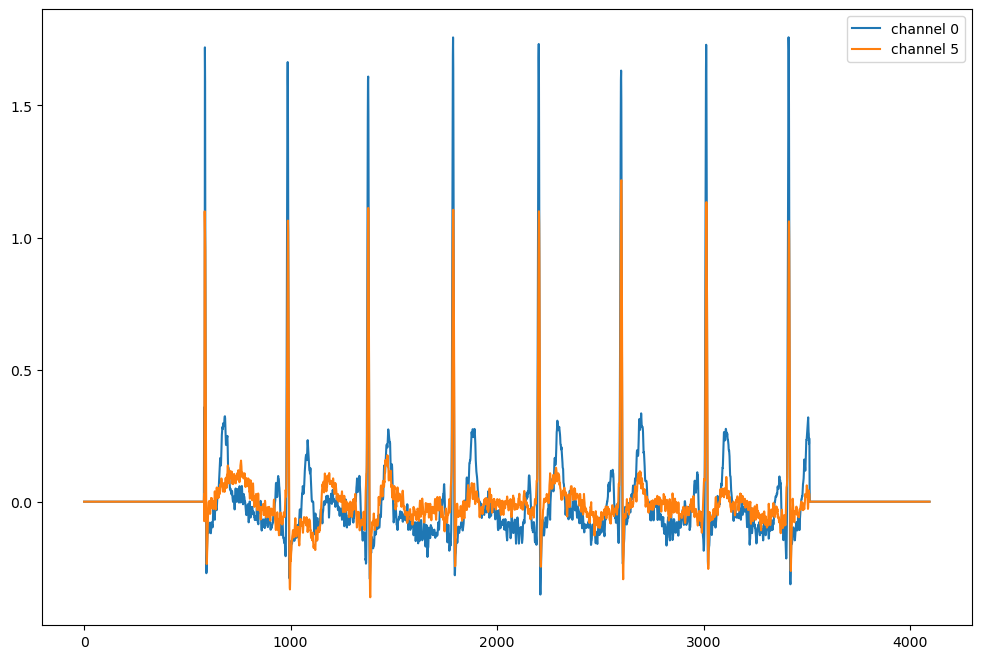

In [12]:
plt.figure(figsize=(12, 8))
i = 0
plt.plot(trace[:, i], label=f"channel {i}")  # first ECG channel
i = 5
plt.plot(trace[:, i], label=f"channel {i}")  # 8th ECG channel
plt.legend()

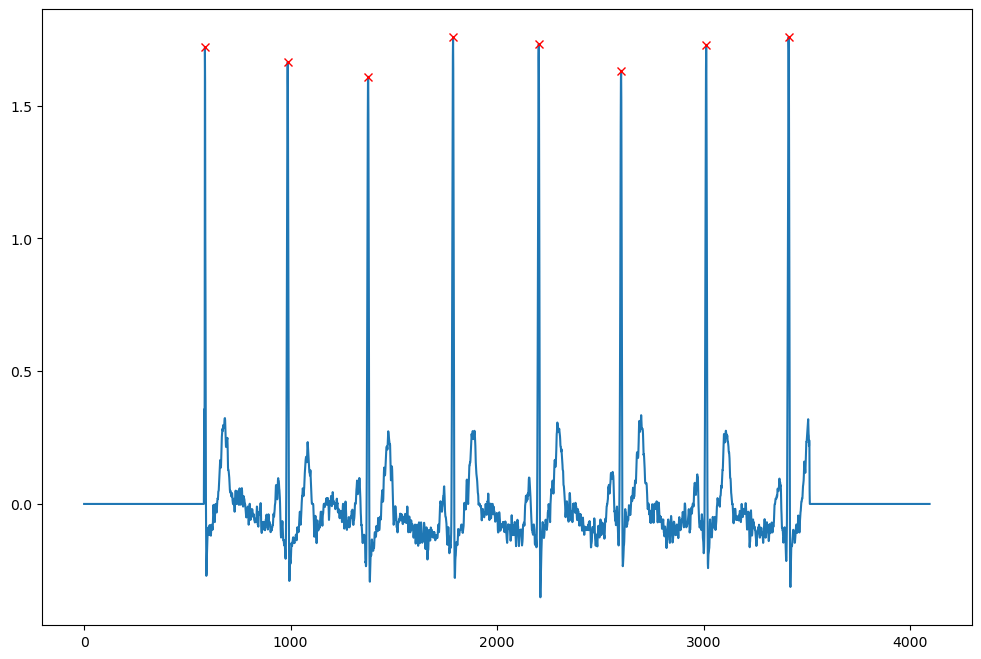

In [13]:
chan = 0

trace_plt = trace[:, chan]
trace_mean = np.mean(trace_plt)
peaks, _ = find_peaks(
    trace_plt,
    height=0.5,
    prominence= [trace_mean],
)
plt.figure(figsize=(12, 8))
plt.plot(trace_plt)
plt.plot(peaks, trace_plt[peaks], "x", color='r')
plt.show()

# The code below is test code. It would still work

In [14]:
x = np.load("../output/p16/p16_age_diff_1_orig.npy")

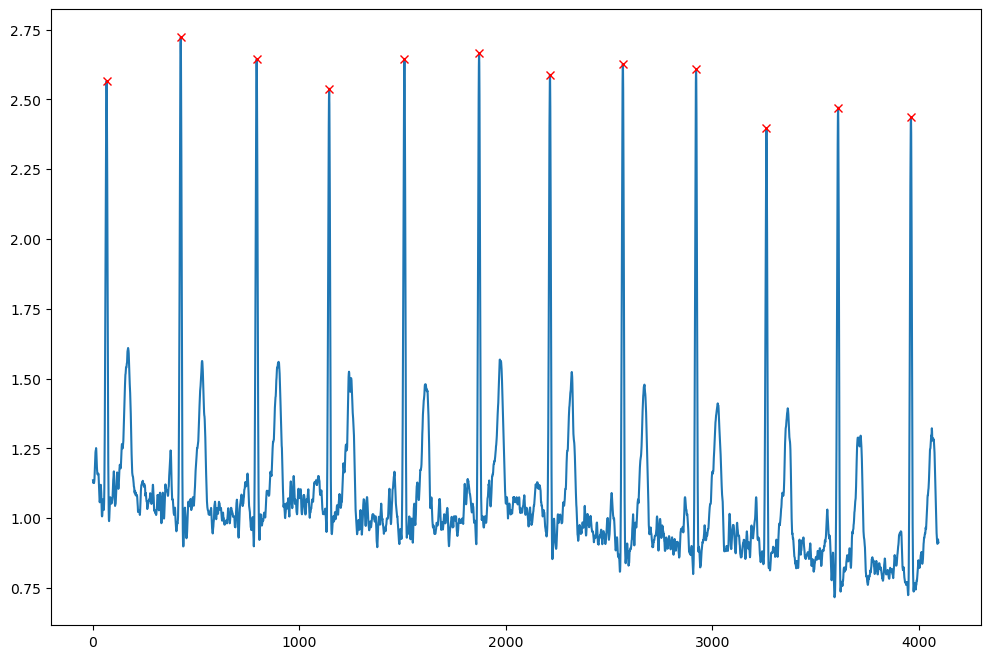

In [15]:
trace = x[0, :, 0]
trace_mean = np.mean(trace)
peaks, _ = find_peaks(
    trace,
    height=0,
    prominence=[trace_mean],
)
plt.figure(figsize=(12, 8))
plt.plot(trace)
plt.plot(peaks, trace[peaks], "x", color='r')
plt.show()

In [16]:
peaks

array([  66,  425,  793, 1144, 1508, 1870, 2213, 2566, 2921, 3262, 3609,
       3962])

In [17]:
zero_padded_trace = np.zeros_like(trace)
zero_padded_trace[peaks[0]: peaks[1]] = trace[peaks[0]: peaks[1]]

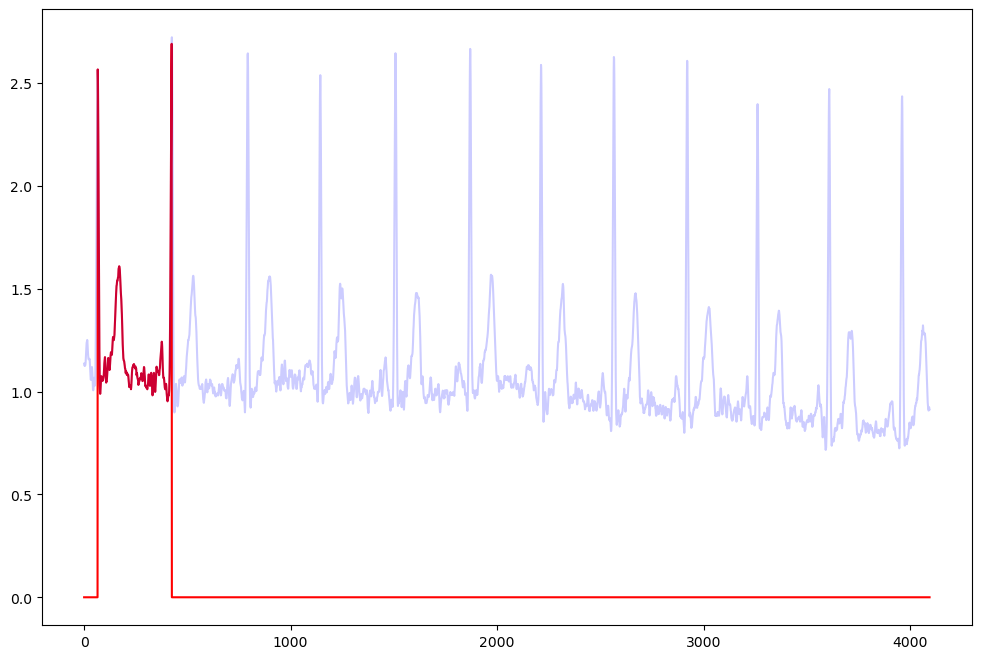

In [18]:
plt.figure(figsize=(12, 8))
plt.plot(zero_padded_trace, color='red')
plt.plot(trace, color='blue', alpha=0.2)